## Load packages

In [2]:
%matplotlib inline 
import rdflib, glob, pandas as pd
from rdflib import URIRef
from rdflib.namespace import RDF, RDFS

## Define namespaces

In [3]:
abri = rdflib.Namespace("https://w3id.org/anything-but-routine/4.0/instance/")
abrw = rdflib.Namespace("https://w3id.org/anything-but-routine/4.0/work/")
bf = rdflib.Namespace("http://id.loc.gov/ontologies/bibframe/")
arm = rdflib.Namespace("https://w3id.org/arm/core/ontology/0.1/")

## Parse all edited .ttl files into a graph

In [4]:
def initialize_abr_graph():
    g = rdflib.Graph()
    g.bind("abri", "https://w3id.org/anything-but-routine/4.0/instance/")
    g.bind("abrw", "https://w3id.org/anything-but-routine/4.0/work/")
    g.bind("bf", "http://id.loc.gov/ontologies/bibframe/")
    g.bind("arm", "https://w3id.org/arm/core/ontology/0.1/")
    return g

In [5]:
g = initialize_abr_graph()
for infile in glob.glob("edited-ttl/*/*.ttl"):
    g.parse(infile, format='n3')
n = len(g)
print(f"ABR graph has {n} triples.")

ABR graph has 8685 triples.


## Query the graph to create a dataframe

In [6]:
qres = g.query(
    """SELECT ?title ?abrno ?date ?i
       WHERE {
          ?w rdf:type bf:Work .
          ?w rdfs:label ?title .
          ?i bf:instanceOf ?w .
          ?i bf:identifiedBy ?id .
          ?id bf:source 'Schottlaender v4.0' .
          ?id rdf:value ?abrno .
          ?i bf:provisionActivity ?pa .
          ?pa bf:date ?date .
       }
       ORDER BY ASC(?date)""")

results = [ [row[0].toPython(), row[1].toPython(), row[2].toPython(), row[3].toPython() ] for row in qres ]
instance_df = pd.DataFrame(results, columns=['worktitle', 'id', 'date', 'instance'])
instance_df['workid'] = instance_df['id'].str[1:-1]
instance_df['workid'] = instance_df['workid'].apply(pd.to_numeric)
instance_df['instanceltr'] = instance_df['id'].str[-1]
instance_df['instanceltr'] = instance_df['instanceltr'].str.upper()
instance_df['year'] = instance_df['date'].str.extract('\[?(\d\d\d\d)', expand=False)
instance_df = instance_df.sort_values(by=['workid', 'instanceltr'])

## Use the dataframe to generate a Markdown catalog

In [7]:
instances = instance_df[['year', 'workid', 'worktitle', 'instanceltr', 'instance']].to_dict('records')
terminating_chars = ['!', '?', '.']

with open('abr-A-list.md', 'w') as mdfile:
    print("# A. BOOKS, BROADSIDES, AND PAMPHLETS", file=mdfile)
    print('', file=mdfile)
    current_work = None
    current_work_title = None
    current_year = '0000'
    for i in instances:
        if i['workid'] != current_work:
            if i['year'] > current_year:
                current_year = i['year']
                print(f"## {current_year}", file=mdfile)
            current_work = i['workid']
            current_work_title = i['worktitle']
            if current_work_title[-1] in terminating_chars:
                print(f"### A{current_work}. _{current_work_title}_", file=mdfile)
            else:
                print(f"### A{current_work}. _{current_work_title}._", file=mdfile)
        instance = URIRef(i['instance'])
        entry = ''
        ids = {}
        for id in g.objects(instance, bf.identifiedBy):
            ids['{}'.format(g.value(id, bf.source))] = '{}'.format(g.value(id, RDF.value))
        # Schottlaender no. + bf:title
        # titles can be more complex
        schottlaender_id = ids['Schottlaender v4.0']
        title = g.value(g.value(instance, bf.title), RDFS.label)
        if title[-1] in terminating_chars:
            entry += '#### {}. _{}_ '.format(schottlaender_id[-1].upper(), title)
        else:
            entry += '#### {}. _{}._ '.format(schottlaender_id[-1].upper(), title)
        # bf:contributor
        for contributor in g.objects(instance, bf.contributor):
            agent = g.value(contributor, RDFS.label)
            # agents can have more than one role
            roles = ''
            for role in g.objects(contributor, bf.role):
                roles += '{}, '.format(role)
            roles = roles[:-2]
            entry += '{}, {}; '.format(agent, roles)
        entry = "{}. ".format(entry[:-2])
        # bf:provisionActivity
        for publisher in g.objects(instance, bf.provisionActivity):
            # provisionActivities can have more than one place
            place = g.value(publisher, bf.place)
            # provisionActivities can have more than one agent
            agent = g.value(publisher, bf.agent)
            date = g.value(publisher, bf.date)
            entry += '{}: {}, {}; '.format(place, agent, date)
        entry = "{}. ".format(entry[:-2])
        # bf:copyrightDate
        if g.value(instance, bf.copyrightDate):
            entry += '©{}. '.format(g.value(instance, bf.copyrightDate))
        # M&M no. (if present)
        if 'Maynard & Miles' in ids:
            entry += '{' + 'M&M {}'.format(ids['Maynard & Miles']) + '}'
        print(entry, file=mdfile)
        print('', file=mdfile)
        # bf.note
        for note in g.objects(instance, bf.note):
            print('- {}'.format(g.value(note, RDF.value)), file=mdfile)
        print('', file=mdfile)

## Use the dataframe to plot publications over year

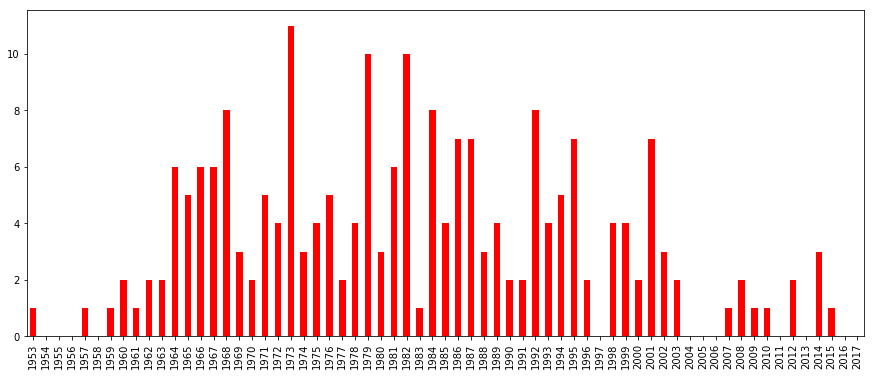

In [8]:
pub_years = instance_df['year'].value_counts().to_dict()
for year in range(1953, 2018):
    if '{}'.format(year) not in pub_years:
        pub_years['{}'.format(year)] = 0
pub_df = pd.DataFrame({'year': pub_years })
pub_df['year'].plot(kind='bar',figsize=[15, 6], color='red')